In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="c1oTfD3urNst79aAlt3J")
project = rf.workspace("tishas-workspace").project("traffic-congestion-detection-16ol4")
version = project.version(2)
dataset = version.download("yolov9")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyte


Extracting Dataset Version Zip to Traffic-Congestion-Detection-2 in yolov9:: 100%|██████████| 47532/47532 [00:07<00:00, 5968.26it/s]


In [ ]:
import shutil
import os

# Define source and destination directories
src_directory = "/kaggle/input/tcd-yolov9-model-runs"
dst_directory = "/kaggle/working"

# Copy the entire directory with dirs_exist_ok=True
shutil.copytree(src_directory, dst_directory, dirs_exist_ok=True)

print(f"Copied {src_directory} to {dst_directory} successfully!")


Copied /kaggle/input/tcd-yolov9-model-runs to /kaggle/working successfully!


In [ ]:
pip install matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import yaml

# Define the new content to be written into the YAML file
new_content = {
    'names': [
        'Bike',
        'Bus',
        'Car',
        'Cng',
        'Cycle',
        'Mini-Truck',
        'People',
        'Rickshaw',
        'Truck'
    ],
    'nc': 9,
    'test': '/kaggle/working/Traffic-Congestion-Detection-2/test/images',
    'train': '/kaggle/working/Traffic-Congestion-Detection-2/train/images',
    'val': '/kaggle/working/Traffic-Congestion-Detection-2/valid/images'
}

# Path to the YAML file
yaml_file_path = '/kaggle/working/Traffic-Congestion-Detection-2/data.yaml'

# Write the new content to the YAML file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(new_content, yaml_file, default_flow_style=False)

print("YAML file updated successfully.")


YAML file updated successfully.


In [ ]:
import yaml

# Path to the YAML file
yaml_file_path = '/kaggle/working/Traffic-Congestion-Detection-2/data.yaml'

# Read and print the content of the YAML file
with open(yaml_file_path, 'r') as yaml_file:
    content = yaml.safe_load(yaml_file)

print(yaml.dump(content, default_flow_style=False))


names:
- Bike
- Bus
- Car
- Cng
- Cycle
- Mini-Truck
- People
- Rickshaw
- Truck
nc: 9
test: /kaggle/working/Traffic-Congestion-Detection-2/test/images
train: /kaggle/working/Traffic-Congestion-Detection-2/train/images
val: /kaggle/working/Traffic-Congestion-Detection-2/valid/images



In [ ]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 183 ms, sys: 39.3 ms, total: 222 ms
Wall time: 13.6 s


In [ ]:
import ultralytics
print(ultralytics.__version__)

8.2.48


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [ ]:
! wandb disabled

W&B disabled.


In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = [
        'Bike',
        'Bus',
        'Car',
        'Cng',
        'Cycle',
        'Mini-Truck',
        'People',
        'Rickshaw',
        'Truck'
    ]
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 5 if DEBUG else 50  # Set total epochs to 39 (19 + 20)
    BATCH_SIZE = 6

    BASE_MODEL = 'yolov9e'  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/working/Traffic-Congestion-Detection-2/'
    OUTPUT_DIR = '/kaggle/working/'
    RESUME_PATH = '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt'  # Path to the last.pt file


In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



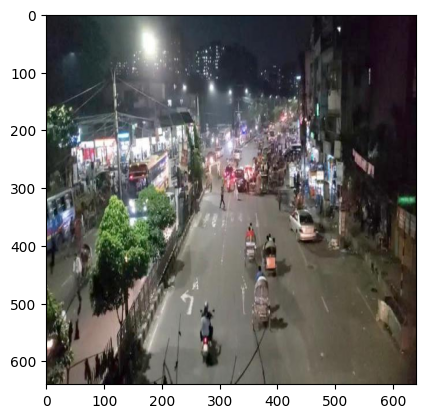

In [ ]:
example_image_path = '/kaggle/working/Traffic-Congestion-Detection-2/train/images/frame250_jpg.rf.f7cd3f3a29e1bdeb735263feb157cc61.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

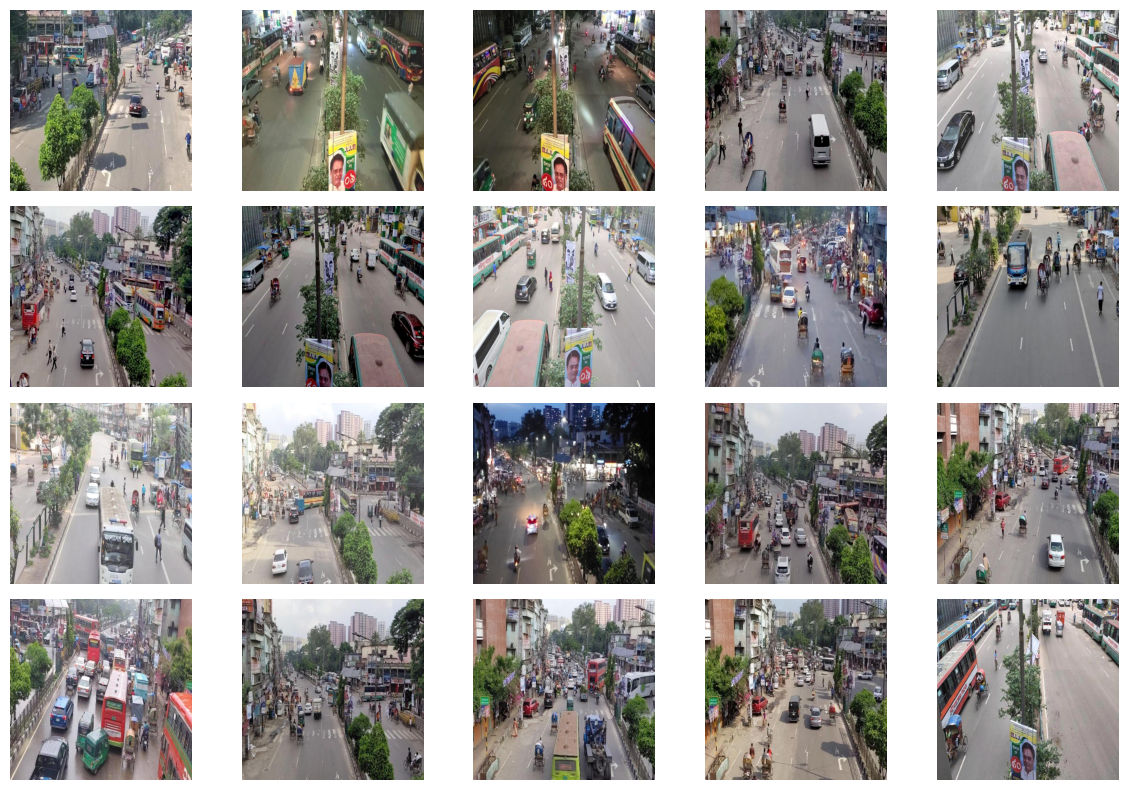

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

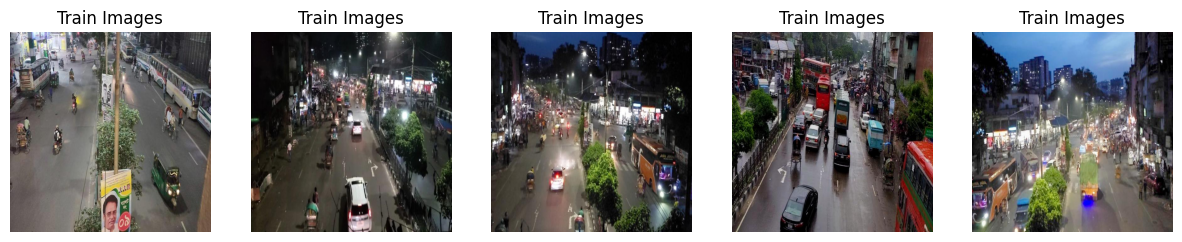

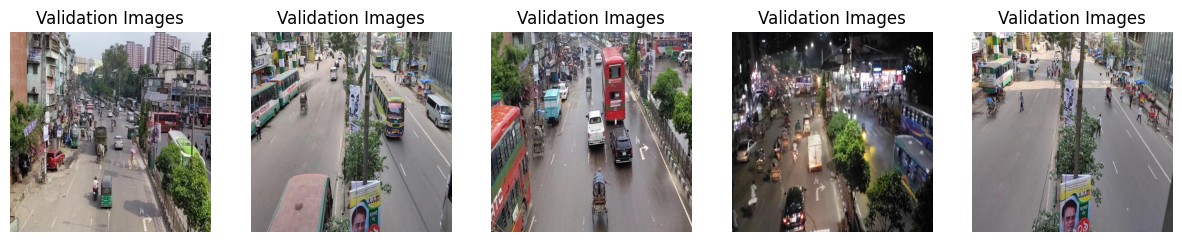

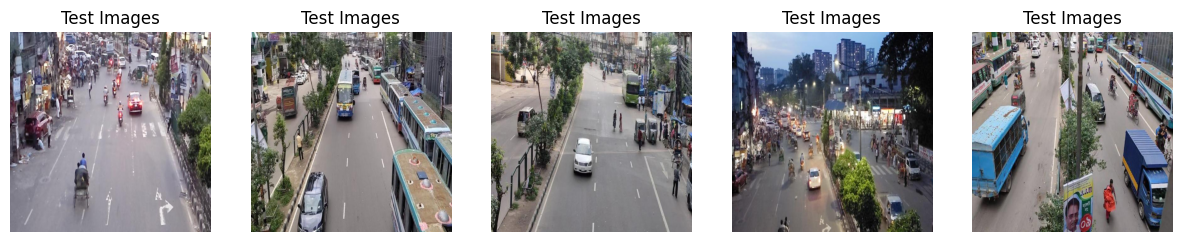

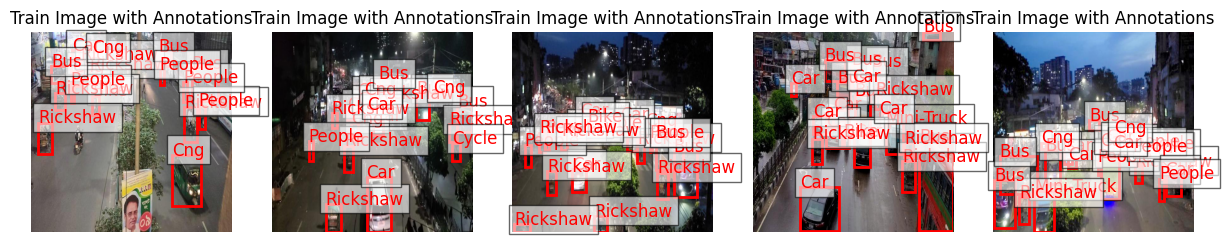

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Rectangle

# Set paths
dataset_dir = '/kaggle/working/Traffic-Congestion-Detection-2/'
train_dir = os.path.join(dataset_dir, 'train', 'images')
val_dir = os.path.join(dataset_dir, 'valid', 'images')
test_dir = os.path.join(dataset_dir, 'test', 'images')

# Function to load image paths
def load_image_paths(directory, num_images=5):
    image_files = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith('.jpg')]
    return random.sample(image_files, min(num_images, len(image_files)))

# Function to plot images
def plot_images(image_paths, title):
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Load image paths
train_images = load_image_paths(train_dir)
val_images = load_image_paths(val_dir)
test_images = load_image_paths(test_dir)

# Plot images
plot_images(train_images, 'Train Images')
plot_images(val_images, 'Validation Images')
plot_images(test_images, 'Test Images')

# Function to load annotations
def load_annotations(img_path):
    annot_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    boxes = []
    if os.path.exists(annot_path):
        with open(annot_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot images with annotations
def plot_images_with_annotations(image_paths, class_names):
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes = load_annotations(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Train Image with Annotations')

        for box in boxes:
            class_id, x_center, y_center, width, height = box
            x = int((x_center - width / 2) * img.shape[1])
            y = int((y_center - height / 2) * img.shape[0])
            w = int(width * img.shape[1])
            h = int(height * img.shape[0])
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x, y, class_names[class_id], color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
    plt.show()

# Plot training images with annotations
class_names = [
    'Bike', 'Bus', 'Car', 'Cng', 'Cycle', 'Mini-Truck', 'People', 'Rickshaw', 'Truck'
]
plot_images_with_annotations(train_images, class_names)


In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 2.23 s, sys: 335 ms, total: 2.56 s
Wall time: 2.57 s


In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0], # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:02<00:00, 43.3MB/s]



image 1/1 /kaggle/working/Traffic-Congestion-Detection-2/train/images/frame250_jpg.rf.f7cd3f3a29e1bdeb735263feb157cc61.jpg: 640x640 4 persons, 48.9ms
Speed: 6.0ms preprocess, 48.9ms inference, 271.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



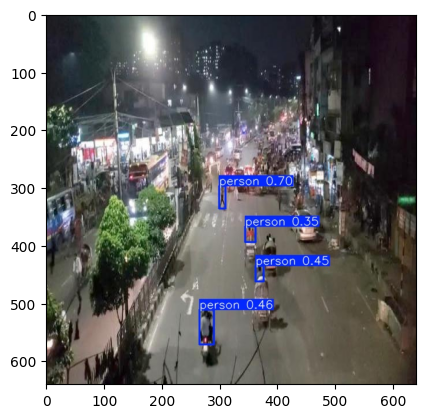

In [ ]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/kaggle/working/runs/detect/predict/{example_image_inference_output}')

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  50
Batch:  6


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.RESUME_PATH)

In [ ]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
%%time

# Continue training
model.train(
    data='/kaggle/working/Traffic-Congestion-Detection-2/data.yaml',

    task='detect',

    imgsz=(img_properties['height'], img_properties['width']),

    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    weight_decay=CFG.WEIGHT_DECAY,
    dropout=CFG.DROPOUT,
    fraction=CFG.FRACTION,
    patience=CFG.PATIENCE,
    profile=CFG.PROFILE,
    label_smoothing=CFG.LABEL_SMOOTHING,

    name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed=CFG.SEED,

    val=True,
    amp=True,
    exist_ok=True,
    resume=True,
    device=[0],  # 0
    verbose=False,
)

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt, data=/kaggle/working/Traffic-Congestion-Detection-2/data.yaml, epochs=50, time=None, patience=20, batch=6, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, ag

100%|██████████| 755k/755k [00:00<00:00, 40.1MB/s]
2024-07-04 12:22:16,452	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-04 12:22:17,280	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov9e_ppe_css_50_epochs', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [

100%|██████████| 6.25M/6.25M [00:00<00:00, 164MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/working/Traffic-Congestion-Detection-2/train/labels... 20790 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20790/20790 [00:17<00:00, 1169.91it/s]


train: New cache created: /kaggle/working/Traffic-Congestion-Detection-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Traffic-Congestion-Detection-2/valid/labels... 1485 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1485/1485 [00:01<00:00, 1078.54it/s]

val: New cache created: /kaggle/working/Traffic-Congestion-Detection-2/valid/labels.cache


Plotting labels to runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.000515625), 309 bias(decay=0.0)
Resuming training /kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt from epoch 38 to 50 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.57G     0.8428     0.4287     0.9338        191        640: 100%|██████████| 3465/3465 [49:44<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:01<00:00,  2.00it/s]

                   all       1485      30425      0.685      0.728      0.732      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       8.3G     0.8403     0.4257     0.9289        121        640: 100%|██████████| 3465/3465 [49:49<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425      0.725      0.687       0.73      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.78G     0.8278     0.4192     0.9232         75        640: 100%|██████████| 3465/3465 [49:48<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:01<00:00,  2.03it/s]

                   all       1485      30425       0.69      0.725      0.731      0.485


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       8.3G     0.7926      0.381     0.9203        110        640: 100%|██████████| 3465/3465 [49:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425      0.696       0.72      0.731      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       8.3G     0.7708     0.3684     0.9141        120        640: 100%|██████████| 3465/3465 [49:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425        0.7      0.714      0.731      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.3G     0.7518     0.3581     0.9089        120        640: 100%|██████████| 3465/3465 [49:46<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:01<00:00,  2.03it/s]

                   all       1485      30425      0.699       0.71       0.73      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       8.3G     0.7361     0.3502     0.9069        118        640: 100%|██████████| 3465/3465 [49:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425      0.697      0.712      0.728      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.29G     0.7207     0.3417     0.9018         91        640: 100%|██████████| 3465/3465 [49:41<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425      0.694       0.71      0.728      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.31G     0.7062     0.3344     0.8961        135        640: 100%|██████████| 3465/3465 [49:41<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425      0.719      0.686      0.725      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       8.3G     0.6933     0.3271      0.891         99        640: 100%|██████████| 3465/3465 [49:41<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.03it/s]

                   all       1485      30425      0.734      0.678      0.724      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.29G     0.6799      0.321     0.8862        116        640: 100%|██████████| 3465/3465 [49:47<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.03it/s]

                   all       1485      30425      0.727      0.682      0.723      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.31G     0.6673     0.3141     0.8829        113        640: 100%|██████████| 3465/3465 [49:41<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]

                   all       1485      30425       0.73       0.68      0.722      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.77G     0.6551     0.3088     0.8792        105        640: 100%|██████████| 3465/3465 [49:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:01<00:00,  2.03it/s]

                   all       1485      30425      0.721      0.687       0.72      0.479



13 epochs completed in 11.015 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57383339 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:12<00:00,  1.72it/s]


                   all       1485      30425      0.667      0.764      0.764      0.508
Speed: 0.2ms preprocess, 36.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_50_epochs
CPU times: user 8h 33min 8s, sys: 2h 35min 4s, total: 11h 8min 12s
Wall time: 11h 3min 13s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78515d17c280>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57383339 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 13, 8400) (111.8 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 8.4s, saved as 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx' (219.3 MB)

Export complete (9.9s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx imgsz=640 data=/kaggle/working/Traffic-Congestion-Detection-2/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx'

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg']

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1         1.43770         1.04230         1.20190   
1       2         1.34020         0.80488         1.12840   
2       3         1.34660         0.81218         1.13110   
3       4         1.33800         0.80875         1.13530   
4       5         1.29970         0.77496         1.11690   
5       6         1.27550         0.75151         1.10680   
6       7         1.25300         0.73477         1.09310   
7       8         1.23390         0.71677         1.08570   
8       9         1.21800         0.70312         1.08470   
9      10         1.20350         0.69149         1.07750   
10     11         1.18600         0.67630         1.06790   
11     12         1.17380         0.66587         1.06480   
12     13         1.16000         0.65515         1.05980   
13     14         1.14930         0.64678         1.05160   
14     15         1.13570         0.63643         1.04950   
15     16         1.12180         0.62404         1.04420   
16     17         1.10900         0.61468         1.03560   
17     18         1.09770         0.60464         1.03200   
18     19         1.08420         0.59543         1.02200   
19     20         1.06940         0.58309         1.02150   
20     21         1.05950         0.57579         1.01960   
21     22         1.04550         0.56593         1.01360   
22     23         1.03660         0.55978         1.00960   
23     24         1.02170         0.54788         1.00280   
24     25         1.01070         0.54027         0.99721   
25     26         0.99937         0.53175         0.99088   
26     27         0.98399         0.52134         0.98890   
27     28         0.97201         0.51336         0.97687   
28     29         0.95982         0.50552         0.97204   
29     30         0.94613         0.49612         0.97155   
30     31         0.93280         0.48678         0.96297   
31     32         0.92006         0.47830         0.96246   
32     33         0.91086         0.47177         0.95980   
33     34         0.89727         0.46326         0.95286   
34     35         0.88612         0.45520         0.95060   
35     36         0.87407         0.44841         0.94733   
36     37         0.86117         0.44102         0.94293   
37     38         0.84276         0.42870         0.93376   
38     39         0.84032         0.42571         0.92893   
39     40         0.82782         0.41923         0.92324   
40     41         0.79257         0.38104         0.92030   
41     42         0.77081         0.36839         0.91412   
42     43         0.75177         0.35811         0.90894   
43     44         0.73614         0.35019         0.90688   
44     45         0.72073         0.34172         0.90183   
45     46         0.70624         0.33442         0.89614   
46     47         0.69328         0.32706         0.89095   
47     48         0.67992         0.32096         0.88622   
48     49         0.66727         0.31415         0.88292   
49     50         0.65512         0.30883         0.87922   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                0.73254            0.60269           0.67224   
1                0.62339            0.65833           0.69404   
2                0.63188            0.63636           0.69192   
3                0.65359            0.65950           0.70715   
4                0.62129            0.67602           0.70719   
5                0.61484            0.69680           0.71179   
6                0.65314            0.68991           0.71995   
7                0.76881            0.65470           0.72300   
8                0.67375            0.70841           0.73826   
9                0.72248            0.67323           0.74105   
10               0.68950            0.69879           0.74258   
11               0.66161            0.71739           0.74257   
12               0.70446            0.72428    

In [ ]:
import os
import zipfile

def zip_directory(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Specify the directory you want to zip
directory_to_zip = '/kaggle/working/runs'

# Specify the output zip file path
output_zip_file = '/kaggle/working/runs.zip'

# Create the zip file
zip_directory(directory_to_zip, output_zip_file)

print(f"Directory '{directory_to_zip}' has been zipped to '{output_zip_file}'")


Directory '/kaggle/working/runs' has been zipped to '/kaggle/working/runs.zip'


/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png


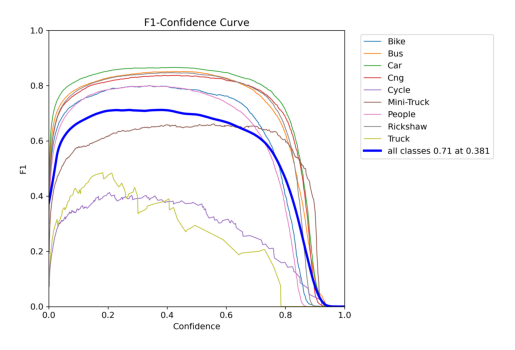



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png


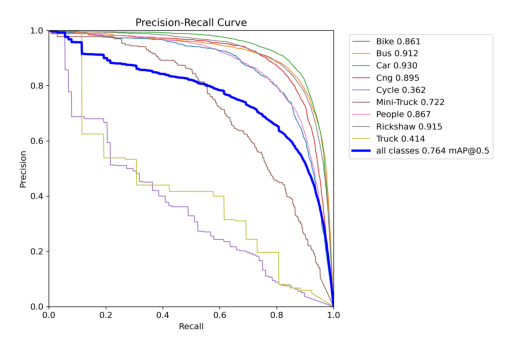



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png


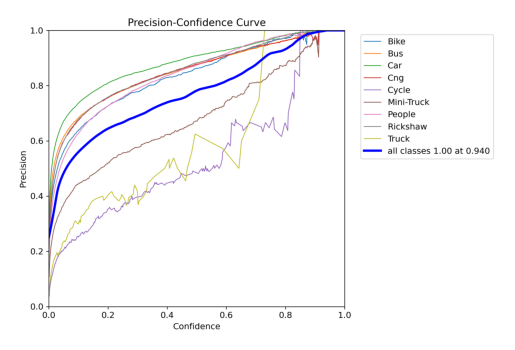



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png


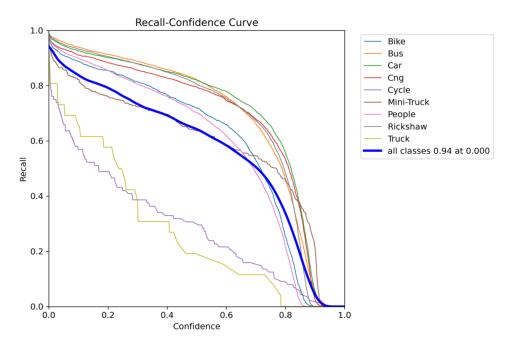



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png


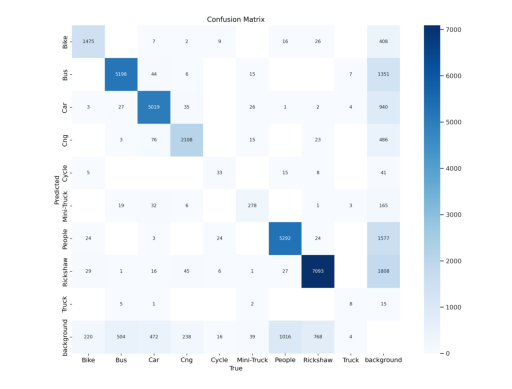



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png


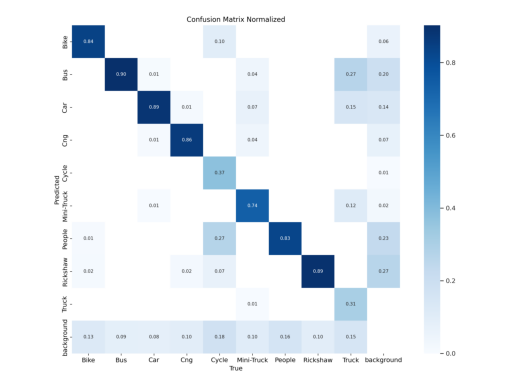



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg


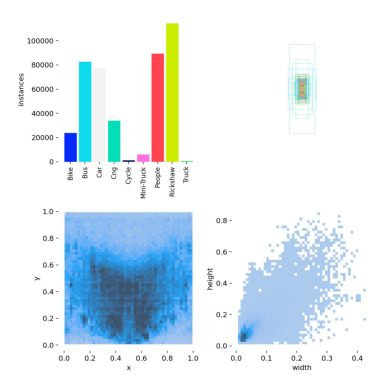



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg


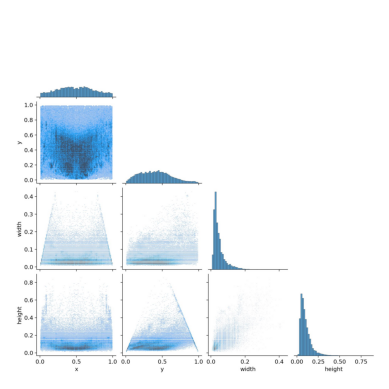



/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/results.png


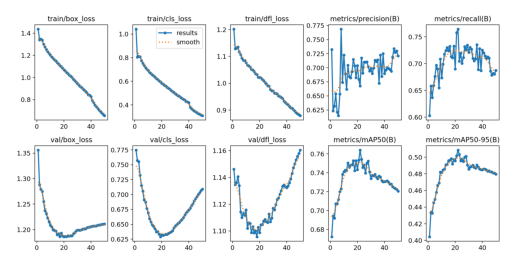

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.65512 , on epoch:  50 


Best Validation Box loss:  1.186 , on epoch:  20 


Best Training Cls loss:  0.30883 , on epoch:  50 


Best Validation Cls loss:  0.62903 , on epoch:  19 


Best Training DFL loss:  0.87922 , on epoch:  50 


Best Validation DFL loss:  1.0957 , on epoch:  18 



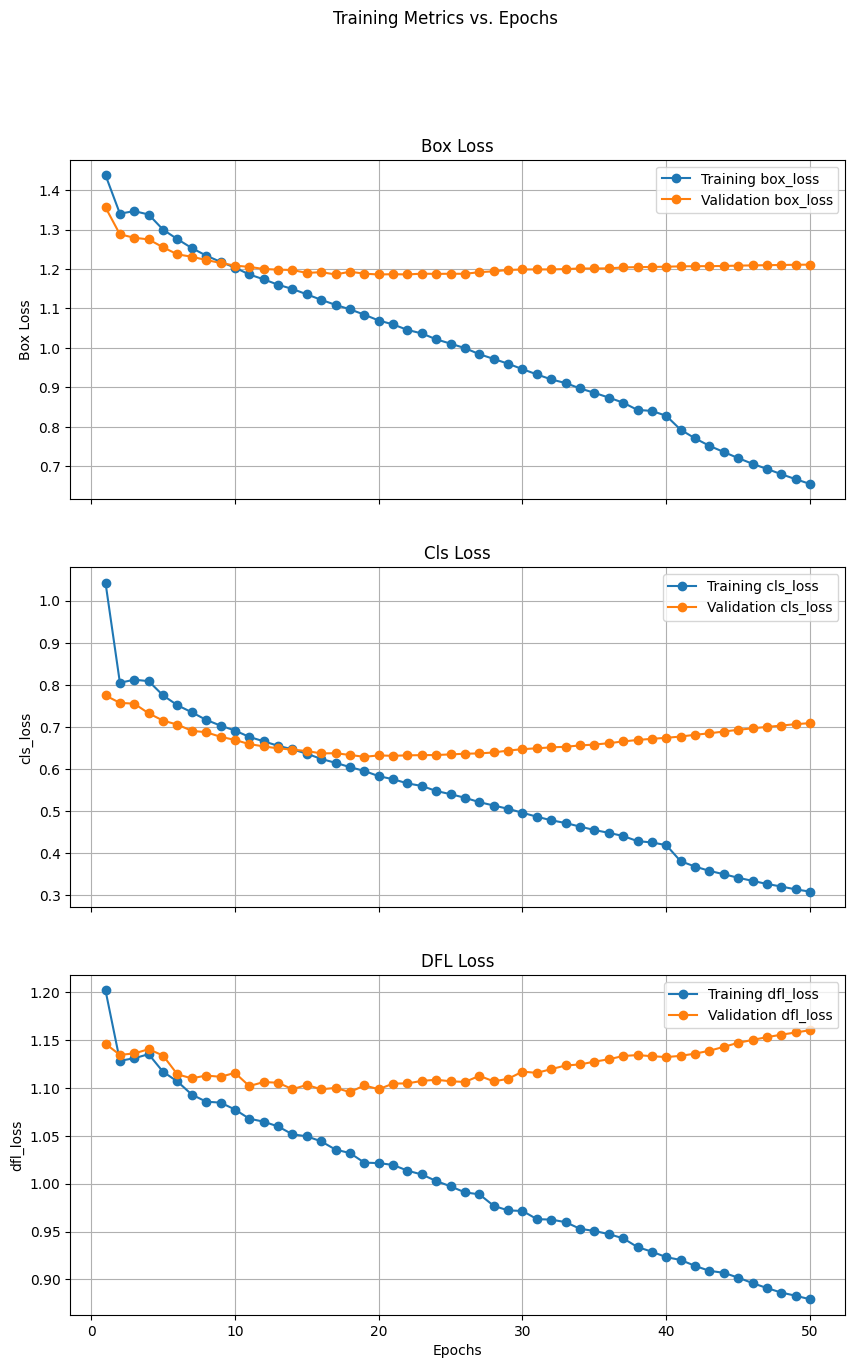

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])


/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/val_batch1_pred.jpg


/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/val_batch0_labels.jpg


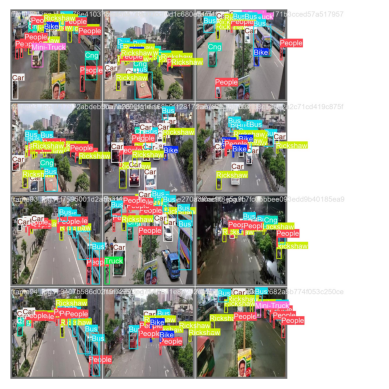

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)